### Level 1

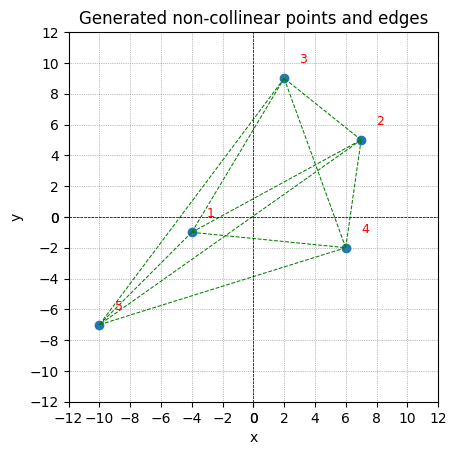

points:
x     y
-4    -1
7     5
2     9
6     -2
-10   -7

circular sequence
2 4 3 1 5 
2 3 4 1 5 
3 2 4 1 5 
3 2 1 4 5 
3 2 1 5 4 
3 1 2 5 4 
3 1 5 2 4 
3 5 1 2 4 
5 3 1 2 4 
5 1 3 2 4 
5 1 3 4 2 

crossing number: 3


In [15]:
import sys, math, random, itertools
import numpy as np
import matplotlib.pyplot as plt

def slope(p1, p2): # calculate slope between two points
  x1, y1 = p1
  x2, y2 = p2
  if x1 == x2:
    return -np.inf # vertical line
  else:
    return (y1 - y2) / (x1 - x2)

def init_points_and_slopes(n=4, min_coord=-10, max_coord=10):
  points = np.zeros((n, 2)) # store points
  slopes = np.zeros((n, n)) # store slopes
  ct = 0 # track number of points generated
  while ct < n:
    x, y = random.randint(min_coord, max_coord), random.randint(min_coord, max_coord) # randomly generate point
    new_slopes = np.array([slope((x, y), p) for p in points[:ct]]) # find slopes with existing points
    if (x, y) not in points and len(np.unique(new_slopes)) == len(new_slopes): # check if all slopes unique (otherwise, collinear triad exists)
      points[ct] = np.array([x, y]) # add point
      slopes[ct,:ct] = new_slopes # add slopes
      slopes[:ct,ct] = new_slopes
      ct += 1
  return points, slopes

def generate_initial_seq_and_swap_seq(points, slopes):
  n = len(points)
  initial = [ind[0] + 1 for ind in sorted(enumerate(points), key=lambda p: p[1][0], reverse=True)] # begin facing south 
  swaps = sorted([(i + 1, j + 1) for i in range(n) for j in range(i)], key=lambda s: slopes[s[0] - 1][s[1] - 1]) # sort slopes to get swapping order
  return initial, swaps

def generate_circular_sequence(initial, swaps):
  n = len(initial)
  edg = np.zeros(n - 1) # store number of j-edges
  circ = np.zeros((n * (n - 1) // 2 + 1, n)) # store circular sequence
  seq = initial
  circ[0] = seq
  for ind, slope in enumerate(swaps): # iterate through swaps
    i, j = slope
    tmpsq = seq.copy() # swap positions
    edg[min(seq.index(i), seq.index(j))] += 1
    tmpsq[seq.index(i)], tmpsq[seq.index(j)] = j, i
    circ[ind + 1] = tmpsq
    seq = tmpsq
  return circ, edg

def calculate_cr(n, edg):
  return int(sum([edg[j] * ((n - 2) * (n - 3) / 4 - j * (n - j - 2)) for j in range(n - 1)]))

def print_points(points, min_coord, max_coord):
  print("points:")
  pad = 2 * max(len(str(int(min_coord))), len(str(int(max_coord))))
  print("x".ljust(pad) + "y")
  for p in points:
    x, y = p
    print(f"{int(x)}".ljust(pad) + f"{int(y)}")

def print_circular_sequence(n, circ):
  print("circular sequence")
  pad = 2 * len(str(n))
  for c in circ:
    print("".join([f"{int(i)}".ljust(pad) for i in c]))

n = 5
min_coord = -10
max_coord = 10
step = 2
ext = 2

points, slopes = init_points_and_slopes(n, min_coord, max_coord)
initial, swaps = generate_initial_seq_and_swap_seq(points, slopes)
circ, edg = generate_circular_sequence(initial, swaps)
cr = calculate_cr(n, edg)

plt.scatter(points[:,0], points[:,1]) # plot points
for ind, p in enumerate(points): # plot labels
  plt.text(p[0] + 1, p[1] + 1, f"{ind+1}", color='red', fontsize=9)
for e in itertools.combinations(points, 2): # plot edges
  x1, y1 = e[0]
  x2, y2 = e[1]
  plt.plot([x1, x2], [y1, y2], color='green', linestyle='--', linewidth=0.75)

# visuals
plt.xlim(min_coord - ext, max_coord + ext)
plt.ylim(min_coord - ext, max_coord + ext)
ticks = np.concatenate((np.arange(0, min_coord - step - 1, -step), np.arange(0, max_coord + step + 1, step)))
plt.xticks(ticks)
plt.yticks(ticks)
plt.axhline(0, color='black', linewidth=0.5, linestyle='--')
plt.axvline(0, color='black', linewidth=0.5, linestyle='--')
plt.gca().set_aspect('equal') 
plt.grid(color='gray', linestyle=':', linewidth=0.5)
plt.title('Generated non-collinear points and edges')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

print_points(points, min_coord, max_coord)
print("")
print_circular_sequence(n, circ)
print("")
print("crossing number:", cr)

### Level 2

circular sequence
1 2 3 4 
3 2 1 4 
3 2 4 1 
4 2 3 1 
4 1 3 2 
2 1 3 4 
3 1 2 4 


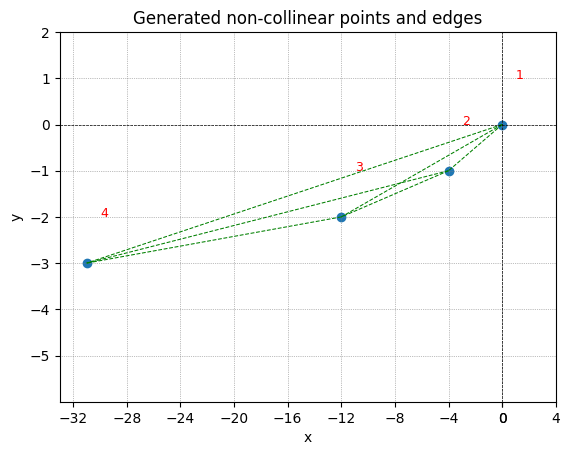

points:
x     y
0     0
-4    -1
-12   -2
-31   -3

# verify circular sequence
circular sequence
1 2 3 4 
3 2 1 4 
3 2 4 1 
4 2 3 1 
4 1 3 2 
2 1 3 4 
3 1 2 4 


In [16]:
def generate_points(n, swaps):
  points = np.zeros((n, 2)) # store points
  slopes = np.zeros((n, n)) # store slopes
  for i in range(n):
    points[i] = np.array([0, -i])
  for ind, s in enumerate(swaps):
    i, j = s[0] - 1, s[1] - 1
    points[j:, 0] -= (j - i) * (ind + 1)
    slopes[i, j], slopes[j, i] = ind + 1, ind + 1
  return points, slopes

n = 4
circ = np.zeros((n * (n - 1) // 2 + 1, n))
initial = list(np.arange(1, n + 1, 1))
swaps = list(itertools.combinations(initial, 2))
random.shuffle(swaps)
circ, edg = generate_circular_sequence(initial, swaps)
print_circular_sequence(n, circ)

points, slopes = generate_points(n, swaps)
min_coord = np.min(points)
max_coord = np.max(points)
step = 4
ext = 2

plt.scatter(points[:,0], points[:,1]) # plot points
for ind, p in enumerate(points): # plot labels
  plt.text(p[0] + 1, p[1] + 1, f"{ind+1}", color='red', fontsize=9)
for e in itertools.combinations(points, 2): # plot edges
  x1, y1 = e[0]
  x2, y2 = e[1]
  plt.plot([x1, x2], [y1, y2], color='green', linestyle='--', linewidth=0.75)

# visuals
plt.xlim(min_coord - ext, max_coord + ext)
plt.ylim(-n - ext, -ext)
ticks = np.concatenate((np.arange(0, min_coord - step - 1, -step), np.arange(0, max_coord + step + 1, step)))
plt.xticks(ticks)
plt.yticks(np.arange(ext, -n - ext, -1))
plt.axhline(0, color='black', linewidth=0.5, linestyle='--')
plt.axvline(0, color='black', linewidth=0.5, linestyle='--') 
plt.grid(color='gray', linestyle=':', linewidth=0.5)
plt.title('Generated non-collinear points and edges')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

print_points(points, min_coord, max_coord)

initial, swaps = generate_initial_seq_and_swap_seq(points, slopes)
circ, edg = generate_circular_sequence(initial, swaps)
print("")
print("# verify circular sequence")
print_circular_sequence(n, circ)

previous work

The set of points is:  [[0, 0], [-2, -1], [-17, -2], [-34, -3]]
The circular sequences is: 
[1, 2, 3, 4]
[1, 2, 4, 3]
[1, 4, 2, 3]
[1, 4, 3, 2]
[4, 1, 3, 2]
[4, 3, 1, 2]
[4, 3, 2, 1]
[1, 2, 3, 0]
cr is 1.0


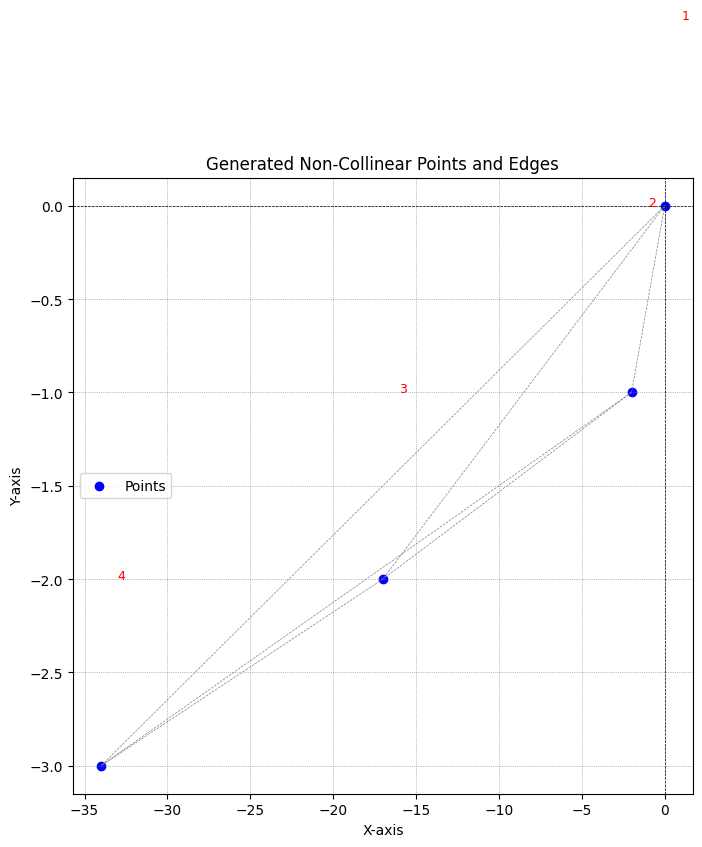

In [13]:
import random
import numpy as np
import matplotlib.pyplot as plt

NUM_POINT = 4 # How many number to generate 

def sort_points_by_x(points): # sort points by x coordinates
    return sorted(points,key=lambda l:l[0])

def generate_non_collinear_points(n, min_val=-100, max_val=100):
    points = []
    while len(points) < n:
        x, y = random.randint(min_val, max_val), random.randint(min_val, max_val)
        # Temporarily add the new point
        temp_points = points + [(x, y)]
        if len(temp_points) < 3 or not are_more_than_three_collinear(temp_points):
            points.append((x, y))
    points = sort_points_by_x(points)
    return points

def are_more_than_three_collinear(points):  # if 3 points are collinear, then it must have the same slope
    n = len(points)
    for i in range(n):
        slopes = {}
        for j in range(n):
            if i != j:
                dx = points[j][0] - points[i][0]
                dy = points[j][1] - points[i][1]
                if dx == 0:
                    s = float('inf')  # Represent vertical slope
                else:
                    s = dy / dx
                slopes[s] = slopes.get(s, 0) + 1
        if any(count >= 2 for count in slopes.values()):
            return True
    return False

def find_slope(p,q): # p,q are lists p = [px,py]; q = [qx,qy], find slope
    if q[0] == p[0]:
        return float('inf')
    delta = (q[1]-p[1]) / (q[0]-p[0])
    return delta

def gather_slope(points): # find nC2 amount of slopes (n points)
    slope_list = []
    n = len(points)
    for i in range(n):
        for j in range(i,n):
            if i != j:
                slope = find_slope(points[i], points[j])
                slope_list.append(slope)
    return slope_list

def nC2(n): # this will print a list of [[1,2], [1,3], [1,4]...[1,n], [2,3], [2,4],...] the orderless nC2 combination
    nC2_list = []
    for i in range(1,n+1):
        for j in range(i+1,n+1):
            element = [i,j]
            nC2_list.append(element)
    return nC2_list

def sort_a_by_b(a,reference): # sort the nC2 comb list by the value of slopes -> circular sequence order
    indices = np.argsort(reference)
    a = [a[i] for i in indices]
    return a

number = NUM_POINT # number of points
points = generate_non_collinear_points(number)
points = [[0, 0], [-2, -1], [-17, -2], [-34, -3]]
print("The set of points is: ", points)
points_C_2 = nC2(number)
slope_list = gather_slope(points)
points_C_2_sorted = sort_a_by_b(points_C_2,slope_list)

# print circular sequence section
def switch_elements(list,u,v):
    a,b = list.index(u),list.index(v)
    list[a],list[b] = list[b],list[a]
    return list

def position_in_list(list,u,v):
    a, b = list.index(u), list.index(v)
    if a<b:
        return a
    else:
        return b

def print_circular_sequence(points_C_2_sorted,number): # create a list like [1,2,3...n] and print after each generation
    cs = []
    cs_position = [0] * number # indicate ej, where the sequence changes
    print("The circular sequences is: ")
    for i in range(number):
        cs.append(i+1)
    print(cs)
    for i in range(len(points_C_2_sorted)):
        u,v = points_C_2_sorted[i]
        cs = switch_elements(cs,u,v)
        position = position_in_list(cs,u,v)
        cs_position[position] += 1
        print(cs)
    return cs_position

cs_position = print_circular_sequence(points_C_2_sorted,number)
print(cs_position)

# apply-formula
def calculate_cr(cs_position,n):
    cr = 0
    for i in range(number-1):
        temp = cs_position[i] * ((n-2)*(n-3)/4 - i*(n-i-2))
        cr += temp
    return cr

print('cr is', calculate_cr(cs_position,number))


# plot section
def find_all_edges(points):
    edges = []
    n = len(points)
    for i in range(n):
        for j in range(i + 1, n):
            edges.append((points[i], points[j]))
    return edges

def plot_points_and_edges(points, edges):
    x_coords = [p[0] for p in points]
    y_coords = [p[1] for p in points]

    plt.figure(figsize=(8, 8))
    plt.scatter(x_coords, y_coords, color='blue', label='Points')
    
    for i, point in enumerate(points):
        plt.text(point[0] + 1, point[1] + 1, f"{i+1}", color='red', fontsize=9)

    for edge in edges:
        x_vals = [edge[0][0], edge[1][0]]
        y_vals = [edge[0][1], edge[1][1]]
        plt.plot(x_vals, y_vals, color='gray', linestyle='--', linewidth=0.5)

    plt.axhline(0, color='black', linewidth=0.5, linestyle='--')
    plt.axvline(0, color='black', linewidth=0.5, linestyle='--')
    plt.grid(color='gray', linestyle=':', linewidth=0.5)
    plt.title('Generated Non-Collinear Points and Edges')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.legend()
    plt.show()

edges = find_all_edges(points)
plot_points_and_edges(points, edges)


### Below is the brute force 

Number of intersections: 1


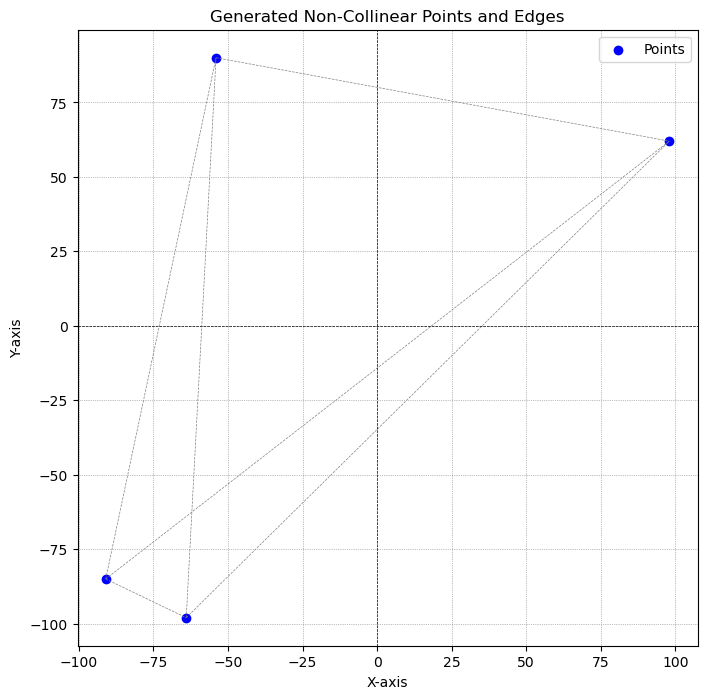

In [264]:

# check if two segment intersect 
def onSegment(p, q, r): 
    if ( (q[0] <= max(p[0], r[0])) and (q[0] >= min(p[0], r[0])) and 
           (q[1] <= max(p[1], r[1])) and (q[1] >= min(p[1], r[1]))): 
        return True
    return False
  
def orientation(p, q, r): 
    val = (q[1] - p[1]) * (r[0] - q[0]) - (q[0] - p[0]) * (r[1] - q[1])
    if (val > 0): 
        return 1
    elif (val < 0): 
        return 2
    else: 
        return 0
  
def doIntersect(p1, q1, p2, q2): 
    # Find orientations
    o1 = orientation(p1, q1, p2) 
    o2 = orientation(p1, q1, q2) 
    o3 = orientation(p2, q2, p1) 
    o4 = orientation(p2, q2, q1) 
    # General case 
    if ((o1 != o2) and (o3 != o4)): 
        return True
    return False
# end of intersect functions 

def generate_non_collinear_points(n, min_val=-100, max_val=100):
    points = []
    while len(points) < n:
        x, y = random.randint(min_val, max_val), random.randint(min_val, max_val)
        # Temporarily add the new point
        temp_points = points + [(x, y)]
        if len(temp_points) < 3 or not are_more_than_three_collinear(temp_points):  
            points.append((x, y))
    return points

def are_more_than_three_collinear(points): # if 3 points are collinear, then it must have the same slope 
    n = len(points)
    for i in range(n):
        slopes = {}
        for j in range(n):
            if i != j:
                dx = points[j][0] - points[i][0]
                dy = points[j][1] - points[i][1]
                if dx == 0:
                    s = float('inf')  # Represent vertical slope
                else:
                    s = dy / dx
                slopes[s] = slopes.get(s, 0) + 1
        if any(count >= 2 for count in slopes.values()):
            return True
    return False

#BF to find all the edges with a given set of points 
def find_all_edges(points):
    edges = []
    n = len(points)
    for i in range(n):
        for j in range(i + 1, n):
            edges.append((points[i], points[j]))
    return edges

# graph plotting 
def plot_points_and_edges(points, edges):
    x_coords = [p[0] for p in points]
    y_coords = [p[1] for p in points]
    
    plt.figure(figsize=(8, 8))
    plt.scatter(x_coords, y_coords, color='blue', label='Points')
    
    for edge in edges:
        x_vals = [edge[0][0], edge[1][0]]
        y_vals = [edge[0][1], edge[1][1]]
        plt.plot(x_vals, y_vals, color='gray', linestyle='--', linewidth=0.5)
    
    plt.axhline(0, color='black', linewidth=0.5, linestyle='--')
    plt.axvline(0, color='black', linewidth=0.5, linestyle='--')
    plt.grid(color='gray', linestyle=':', linewidth=0.5)
    plt.title('Generated Non-Collinear Points and Edges')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.legend()
    plt.show()

edges = find_all_edges(points)

# Count crossings (excluding shared vertices)
c = 0
for i in range(len(edges)):
    for j in range(i + 1, len(edges)): 
        p1, q1 = edges[i]
        p2, q2 = edges[j]
        # Skip if the edges share a vertex
        if len(set([p1, q1, p2, q2])) < 4: # a set cannot have duplicates, so it can check if two edges contains the same vertex 
            continue
        if doIntersect(p1, q1, p2, q2):
            c += 1

print(f"Number of intersections: {c}")

# Plot the points and edges
plot_points_and_edges(points, edges)
